In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-36022ad1-3b01-52a9-f671-0142eff32f72)


In [2]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.7.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import os

np.random.seed(88)
tf.random.set_seed(88)

In [4]:
df = pd.read_csv('./btcthb_daily_5000n_bar.csv', parse_dates=['datetime'])
df = df.sort_values('datetime')
df.head()

,datetime,symbol,open,high,low,close,volume
0,2018-05-09,BITKUB:BTCTHB,293000.0,300000.0,287000.0,295950.0,2.132158
1,2018-05-10,BITKUB:BTCTHB,295950.0,299000.0,289351.0,299000.0,0.536473
2,2018-05-11,BITKUB:BTCTHB,294005.0,296000.0,270150.0,270150.0,1.889688
3,2018-05-12,BITKUB:BTCTHB,270151.0,288253.0,270150.0,280000.0,0.231786
4,2018-05-13,BITKUB:BTCTHB,280000.0,288252.0,277000.0,277200.0,1.817175


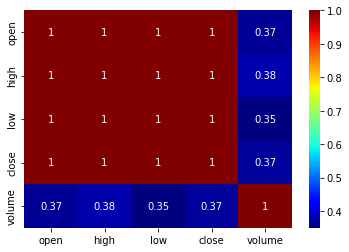

In [5]:
data = df.iloc[:, 2:].copy()

ax = sns.heatmap(data.corr(), cmap='jet', annot=True)

In [6]:
# split_index = round(len(df) * 0.7)

# scaler = StandardScaler()
# scaler.fit(df.iloc[:,2:].values[:split_index])
# dataset = scaler.transform(df.iloc[:,2:].values)

# close = df["close"].values
# scaler_labels = StandardScaler()
# scaler_labels.fit(close[:split_index].reshape(-1, 1))

# train_data = dataset[0:split_index]
# test_data = dataset[split_index:-1]

In [7]:
split_index = len(df) - 30
SEQ_LEN = 15

feature_dataset = df.iloc[:,2:]
label_dataset = df.iloc[:,5]

scaler = MinMaxScaler()
scaler_label = MinMaxScaler()

scaler.fit(feature_dataset.values[:split_index])
scaler_label.fit(label_dataset.values.reshape(-1,1)[:split_index])

feature_dataset = scaler.transform(feature_dataset.values)
label_dataset = scaler_label.transform(label_dataset.values.reshape(-1,1)).reshape(-1)

X_train_data = feature_dataset[0:split_index]
X_test_data = feature_dataset[split_index-SEQ_LEN:]

y_train_data = label_dataset[0:split_index]
y_test_data = label_dataset[split_index-SEQ_LEN:]

In [8]:
def to_sequence(X, y, seq_len):
    train_set, test_set = [], []
    
    for i in range(len(X) - seq_len):
        train_set.append(X[i:i+seq_len])
        test_set.append(y[i+seq_len])
        
    return np.array(train_set), np.array(test_set)

X_train, y_train = to_sequence(X_train_data, y_train_data, SEQ_LEN)
X_test, y_test = to_sequence(X_test_data, y_test_data, SEQ_LEN)

In [9]:
gru_model = tf.keras.models.Sequential()

gru_model.add(tf.keras.layers.Input(shape=(None,X_train.shape[-1])))

gru_model.add(tf.keras.layers.GRU(1028, return_sequences=True))
gru_model.add(tf.keras.layers.Dropout(0.2))

gru_model.add(tf.keras.layers.GRU(512, return_sequences=True))
gru_model.add(tf.keras.layers.Dropout(0.2))

gru_model.add(tf.keras.layers.GRU(256, return_sequences=False))

gru_model.add(tf.keras.layers.Dense(1))

In [10]:
gru_model.compile(loss='mse', optimizer='adam', metrics=[])
checkpoint_filepath = "savemodel/GRU_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

In [11]:
history = gru_model.fit(X_train, y_train, batch_size=128, epochs=300, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/300
9/9 [==============================] - 5s 93ms/step - loss: 0.0478 - val_loss: 0.0148
Epoch 2/300
9/9 [==============================] - 0s 31ms/step - loss: 0.0042 - val_loss: 0.0239
Epoch 3/300
9/9 [==============================] - 0s 31ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 4/300
9/9 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 5/300
9/9 [==============================] - 0s 40ms/step - loss: 7.6621e-04 - val_loss: 0.0044
Epoch 6/300
9/9 [==============================] - 0s 35ms/step - loss: 8.7739e-04 - val_loss: 0.0015
Epoch 7/300
9/9 [==============================] - 0s 19ms/step - loss: 5.9003e-04 - val_loss: 0.0024
Epoch 8/300
9/9 [==============================] - 0s 31ms/step - loss: 5.8084e-04 - val_loss: 0.0012
Epoch 9/300
9/9 [==============================] - 0s 30ms/step - loss: 4.8701e-04 - val_loss: 0.0012
Epoch 10/300
9/9 [==============================] - 0s 31ms/step - loss: 4.1803e-04 - val_loss: 0.

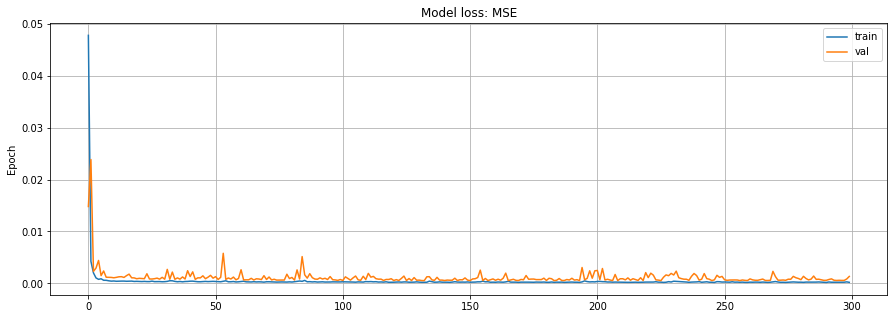

In [12]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss: MSE")
plt.ylabel('Loss')
plt.ylabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [15]:
best_model_path = max( [ f for f in os.listdir("./savemodel") if f.startswith('GRU_best') and f.endswith(".hdf5")] )
best_model_path = "./savemodel/" + best_model_path
print(f"The best model: {best_model_path}")

best_gru_model = tf.keras.models.load_model(best_model_path, compile=True)

The best model: ./savemodel/GRU_bestmodel_epoch194.hdf5


In [16]:
score = best_gru_model.evaluate(X_test, y_test, verbose=0)
print(f"{best_gru_model.metrics_names} = {score}")

['loss'] = 0.0004289255302865058


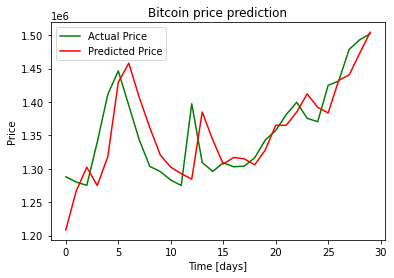

In [17]:
y_predict = best_gru_model.predict(X_test)

y_test_inverse = scaler_label.inverse_transform(y_test.reshape(-1,1))
y_hat_inverse = scaler_label.inverse_transform(y_predict)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [18]:
sse = 0
for i in range(len(y_hat_inverse)):
    sse += ((y_test_inverse[i][0] - y_hat_inverse[i][0]) ** 2)


mse = sse / len(y_hat_inverse)
print(mse)

2014365225.5934842
